# 1

## 

In [2]:
# Code execution state reset 이후 재로드 및 재처리
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans

# 데이터 로드
train_df = pd.read_csv("C:/Users/m/OneDrive - 계명대학교/25-1학기/sas viya/TRAIN_DATA.csv", encoding='cp949')

# 클러스터링용 변수 (전체에서 결측 제거할 수 있는 대표적인 변수들)
top_corr_features = [
    'TOTAL_GAS', 'CMRC_GAS', 'FAC_NEIGH_2', 'FAC_STAY',
    'FAC_RETAIL', 'FAC_CULT_MTG', 'FAC_MEDI', 'FAC_LEISURE'
]
df = train_df.dropna(subset=top_corr_features + ['TOTAL_ELEC']).copy()

# 클러스터링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[top_corr_features])
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# 날짜 분해
df['YEAR'] = df['DATA_YM'].astype(str).str[:4].astype(int)
df['MONTH'] = df['DATA_YM'].astype(str).str[4:].astype(int)

# 전체 변수에서 제외할 컬럼
exclude_cols = [
    'DATA_YM', 'AREA_ID', 'AREA_NM', 'DIST_CD', 'DIST_NM', 
    'TOTAL_ELEC', 'cluster'
]

# 사용할 전체 feature
all_feature_cols = [
    col for col in df.columns 
    if col not in exclude_cols and df[col].dtype in ['float64', 'int64']
] + ['YEAR', 'MONTH']

# 결과 저장
all_results = []

for cluster_id in sorted(df['cluster'].unique()):
    data = df[df['cluster'] == cluster_id]

    X = data[all_feature_cols]
    y = data['TOTAL_ELEC']

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    models = {
        "RandomForest": RandomForestRegressor(random_state=42),
        "XGBoost": XGBRegressor(random_state=42, verbosity=0),
        "Ridge": Ridge()
    }

    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        all_results.append({
            "Cluster": cluster_id,
            "Model": model_name,
            "RMSE": rmse
        })

# 결과 출력
all_results_df = pd.DataFrame(all_results)


C:\Users\m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [3]:
all_results_df

,Cluster,Model,RMSE
0,0,RandomForest,521.175755
1,0,XGBoost,589.055191
2,0,Ridge,1207.890612
3,1,RandomForest,1557.914395
4,1,XGBoost,1449.648676
5,1,Ridge,3032.237784
6,2,RandomForest,477.068134
7,2,XGBoost,414.882791
8,2,Ridge,1156.514833


# 2

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 데이터 불러오기
df = pd.read_csv("C:/Users/m/OneDrive - 계명대학교/25-1학기/sas viya/TRAIN_DATA.csv", encoding='cp949')

# 연월 분리
df['YEAR'] = df['DATA_YM'].astype(str).str[:4].astype(int)
df['MONTH'] = df['DATA_YM'].astype(str).str[4:].astype(int)

# 클러스터링 feature
cluster_features = [
    'TOTAL_GAS', 'CMRC_GAS', 'FAC_NEIGH_2', 'FAC_STAY',
    'FAC_RETAIL', 'FAC_CULT_MTG', 'FAC_MEDI', 'FAC_LEISURE'
]

# 결측치 제거
df = df.dropna(subset=cluster_features + ['TOTAL_ELEC']).copy()

# 외부 검증셋: 상권별 랜덤 1개 샘플
val_df = (
    df.groupby("AREA_ID")
    .apply(lambda x: x.sample(1, random_state=42))
    .reset_index(drop=True)
)
train_df = df.drop(index=val_df.index)

# 클러스터링 (train 기준)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_df[cluster_features])
kmeans = KMeans(n_clusters=3, random_state=42)
train_df['cluster'] = kmeans.fit_predict(X_train_scaled)

# val에도 동일하게 클러스터 부여
X_val_scaled = scaler.transform(val_df[cluster_features])
val_df['cluster'] = kmeans.predict(X_val_scaled)


C:\Users\m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [6]:
from flaml import AutoML
from sklearn.metrics import mean_squared_error

results = []

for cluster_id in sorted(train_df['cluster'].unique()):
    print(f"[CLUSTER {cluster_id}] AutoML 시작")

    # 클러스터별 훈련/검증셋 분리
    train_cluster = train_df[train_df['cluster'] == cluster_id].copy()
    val_cluster = val_df[val_df['cluster'] == cluster_id].copy()

    # 제외할 컬럼
    drop_cols = ['DATA_YM', 'AREA_ID', 'AREA_NM', 'DIST_CD', 'DIST_NM', 'cluster']
    feature_cols = [col for col in train_cluster.columns if col not in drop_cols + ['TOTAL_ELEC']]

    X_train = train_cluster[feature_cols]
    y_train = train_cluster['TOTAL_ELEC']
    X_val = val_cluster[feature_cols]
    y_val = val_cluster['TOTAL_ELEC']

    # FLAML AutoML 설정
    automl = AutoML()
    automl.fit(
        X_train=X_train,
        y_train=y_train,
        task="regression",
        time_budget=300,  # 각 클러스터당 5분
        verbose=0
    )

    # 예측 + RMSE 계산
    y_pred = automl.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    results.append({
        "Cluster": cluster_id,
        "Best_Model": automl.best_estimator,
        "Val_RMSE": rmse
    })

# 결과 출력
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)


[CLUSTER 0] AutoML 시작
[CLUSTER 1] AutoML 시작
[CLUSTER 2] AutoML 시작
   Cluster Best_Model    Val_RMSE
0        0   catboost  318.971881
1        1   catboost  243.021088
2        2   catboost  529.865997


In [5]:
X_train

,TOTAL_BIDG,FAC_NEIGH_1,FAC_NEIGH_2,FAC_CULT_MTG,FAC_RELG,FAC_RETAIL,FAC_MEDI,FAC_YOSE,FAC_TRAIN,FAC_SPORT,FAC_STAY,FAC_LEISURE,TOTAL_GAS,CMRC_GAS,YEAR,MONTH
1221,28.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4938127,2851751,2023,3
1321,373.0,66.0,156.0,2.0,1.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,2968331,2606415,2023,7
1392,276.0,38.0,93.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0,2670334,1324656,2022,12
1510,52.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5970892,879417,2023,1
1524,20.0,2.0,3.0,3.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,4258859,407566,2023,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25876,212.0,46.0,83.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,29.0,0.0,2633495,1455684,2024,1
25910,1513.0,221.0,853.0,1.0,3.0,2.0,0.0,3.0,0.0,0.0,6.0,0.0,5133402,4262726,2023,3
25949,97.0,17.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4727529,247696,2024,3
25974,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2781997,2781997,2023,3


In [8]:
train_df['cluster'].value_counts()


0    21302
1     2764
2      864
Name: cluster, dtype: int64

In [9]:
train_df.groupby('cluster').describe().T


cluster                    0              1              2
DATA_YM count   21302.000000    2764.000000     864.000000
        mean   202321.626749  202316.042692  202323.364583
        std        72.910866      73.768306      69.645886
        min    202207.000000  202207.000000  202207.000000
        25%    202301.000000  202301.000000  202301.000000
...                      ...            ...            ...
MONTH   min         1.000000       1.000000       1.000000
        25%         3.000000       3.000000       1.000000
        50%         7.000000       7.000000       3.000000
        75%        10.000000      10.000000       8.000000
        max        12.000000      12.000000      12.000000

[160 rows x 3 columns]

## 전체 변수 추가

In [4]:
from flaml import AutoML
from sklearn.metrics import mean_squared_error

results = []

for cluster_id in sorted(train_df['cluster'].unique()):
    print(f"[CLUSTER {cluster_id}] 전체 변수 포함 AutoML 시작")

    # 데이터 분리
    train_cluster = train_df[train_df['cluster'] == cluster_id].copy()
    val_cluster = val_df[val_df['cluster'] == cluster_id].copy()

    # 연월 변수 추가 (혹시 없으면)
    for df_ in [train_cluster, val_cluster]:
        df_['YEAR'] = df_['DATA_YM'].astype(str).str[:4].astype(int)
        df_['MONTH'] = df_['DATA_YM'].astype(str).str[4:].astype(int)

    # 숫자형 컬럼만 추출 (타겟/클러스터 제외)
    feature_cols = train_cluster.select_dtypes(include=['number']).columns.tolist()
    feature_cols = [col for col in feature_cols if col not in ['TOTAL_ELEC', 'cluster']]

    X_train = train_cluster[feature_cols]
    y_train = train_cluster['TOTAL_ELEC']
    X_val = val_cluster[feature_cols]
    y_val = val_cluster['TOTAL_ELEC']

    # FLAML 학습
    automl = AutoML()
    automl.fit(
        X_train=X_train,
        y_train=y_train,
        task="regression",
        time_budget=300,
        verbose=0
    )

    # 예측 + RMSE
    y_pred = automl.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    results.append({
        "Cluster": cluster_id,
        "Best_Model": automl.best_estimator,
        "Val_RMSE": rmse
    })

# 결과 출력
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)


NameError: name 'train_df' is not defined

In [7]:
# 코드 실행 상태 초기화로 인한 재시작
import pandas as pd
from flaml import AutoML
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 파일 로드
train_df = pd.read_csv("C:/Users/m/OneDrive - 계명대학교/25-1학기/sas viya/TRAIN_DATA.csv", encoding='cp949')
test_df = pd.read_csv("C:/Users/m/OneDrive - 계명대학교/25-1학기/sas viya/TEST_DATA.csv", encoding='cp949')

# 연월 분리
for df_ in [train_df, test_df]:
    df_['YEAR'] = df_['DATA_YM'].astype(str).str[:4].astype(int)
    df_['MONTH'] = df_['DATA_YM'].astype(str).str[4:].astype(int)

# 클러스터링용 변수 및 결측 제거
cluster_features = [
    'TOTAL_GAS', 'CMRC_GAS', 'FAC_NEIGH_2', 'FAC_STAY',
    'FAC_RETAIL', 'FAC_CULT_MTG', 'FAC_MEDI', 'FAC_LEISURE'
]
df = train_df.dropna(subset=cluster_features + ['TOTAL_ELEC']).copy()

# 클러스터링
scaler = StandardScaler()
X_cluster = scaler.fit_transform(df[cluster_features])
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_cluster)

# test에도 클러스터 부여
test_df = test_df.dropna(subset=cluster_features).copy()
X_test_cluster = scaler.transform(test_df[cluster_features])
test_df['cluster'] = kmeans.predict(X_test_cluster)

# 결과 저장용 리스트
test_preds = []

# 클러스터별 AutoML 학습 + 예측
from sklearn.metrics import mean_squared_error

for cluster_id in sorted(df['cluster'].unique()):
    train_cluster = df[df['cluster'] == cluster_id].copy()
    test_cluster = test_df[test_df['cluster'] == cluster_id].copy()

    # feature 선택
    feature_cols = train_cluster.select_dtypes(include=['number']).columns.tolist()
    feature_cols = [col for col in feature_cols if col not in ['TOTAL_ELEC', 'cluster']]

    X_train = train_cluster[feature_cols]
    y_train = train_cluster['TOTAL_ELEC']
    X_test = test_cluster[feature_cols]

    # AutoML 학습
    automl = AutoML()
    automl.fit(X_train=X_train, y_train=y_train, task="regression", time_budget=300, verbose=0)

    # 예측
    y_test_pred = automl.predict(X_test)
    test_cluster['PRED_TOTAL_ELEC'] = y_test_pred
    test_preds.append(test_cluster[['DATA_YM', 'AREA_ID', 'PRED_TOTAL_ELEC']])

# 결과 병합 및 출력
final_pred_df = pd.concat(test_preds).sort_values(by=['DATA_YM', 'AREA_ID']).reset_index(drop=True)
final_pred_df



C:\Users\m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,DATA_YM,AREA_ID,PRED_TOTAL_ELEC
0,202207,9141,1925.783153
1,202207,9148,155.405604
2,202207,9151,1843.319835
3,202207,9153,731.587573
4,202207,9156,779.562269
...,...,...,...
6520,202410,10349,36.952243
6521,202410,10354,53.209309
6522,202410,10359,43.925507
6523,202410,10360,504.147062


In [8]:
# 예측값을 원래 test_df에 y_pred로 추가
test_df_with_pred = pd.merge(
    test_df,
    final_pred_df.rename(columns={'PRED_TOTAL_ELEC': 'y_pred'}),
    on=['DATA_YM', 'AREA_ID'],
    how='left'
)

# 결과 확인
test_df_with_pred[['DATA_YM', 'AREA_ID', 'y_pred']]


,DATA_YM,AREA_ID,y_pred
0,202303,9180,847.039418
1,202303,9180,843.160382
2,202303,10292,75.445859
3,202303,9323,2517.838705
4,202307,9884,736.520372
...,...,...,...
6992,202310,9239,2103.563661
6993,202211,9798,571.909432
6994,202310,9179,1091.071382
6995,202208,10285,76.726083


In [9]:
test_df_with_pred

,DATA_YM,AREA_ID,AREA_NM,DIST_CD,DIST_NM,TOTAL_BIDG,FAC_NEIGH_1,FAC_NEIGH_2,FAC_CULT_MTG,FAC_RELG,...,FAC_TRAIN,FAC_SPORT,FAC_STAY,FAC_LEISURE,TOTAL_GAS,CMRC_GAS,YEAR,MONTH,cluster,y_pred
0,202303,9180,종로5가역_1,11110,종로구,196.0,81.0,108.0,0.0,0.0,...,0.0,0.0,0.0,0.0,143394,143275,2023,3,2,847.039418
1,202303,9180,종로5가역_1,11110,종로구,196.0,81.0,108.0,0.0,0.0,...,0.0,0.0,0.0,0.0,143394,143275,2023,3,2,843.160382
2,202303,10292,유촌동,29140,서구,17.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3520,2315,2023,3,2,75.445859
3,202303,9323,포스코사거리_2,11680,강남구,93.0,9.0,22.0,0.0,0.0,...,0.0,0.0,2.0,0.0,1548330,515034,2023,3,2,2517.838705
4,202307,9884,장안문로터리_2,41111,수원시 장안구,96.0,9.0,28.0,0.0,0.0,...,0.0,0.0,5.0,0.0,90053,89481,2023,7,2,736.520372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6992,202310,9239,문래동 주민센터,11560,영등포구,15.0,9.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,645566,0,2023,10,2,2103.563661
6993,202211,9798,화순읍,46790,화순군,105.0,36.0,45.0,0.0,0.0,...,0.0,0.0,1.0,1.0,92495,92495,2022,11,2,571.909432
6994,202310,9179,종로3가역_3,11110,종로구,239.0,104.0,78.0,0.0,1.0,...,0.0,0.0,1.0,0.0,35480,30212,2023,10,2,1091.071382
6995,202208,10285,상무지구3,29140,서구,56.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,2022,8,2,76.726083


In [ ]:
test_df_with_pred.to_csv("TEST_DATA_predictions1.csv", index=False, encoding='utf-8-sig')


: 

C:\Users\m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPyth

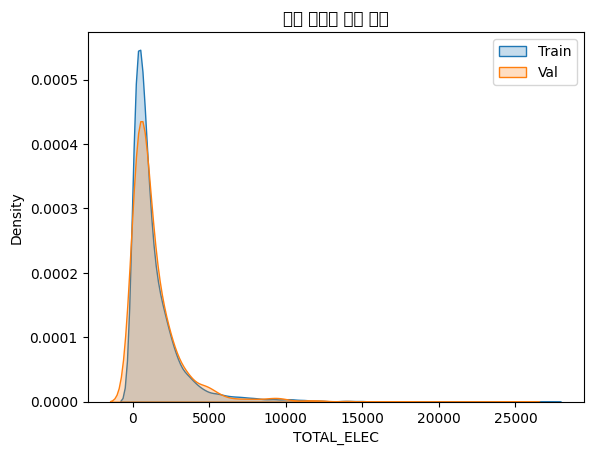

C:\Users\m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPyt

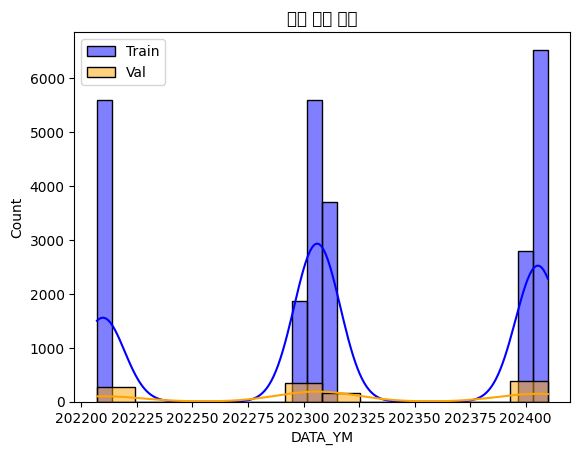

C:\Users\m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPyt

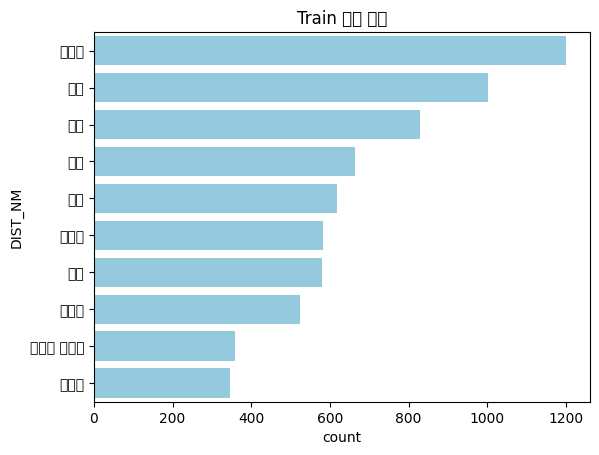

C:\Users\m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPyt

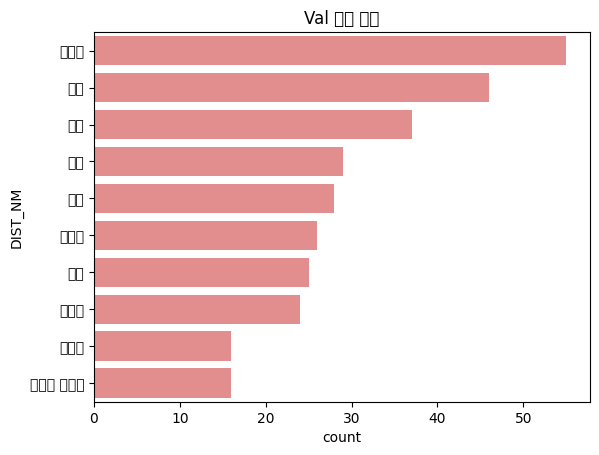

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 전체 vs 검증 TOTAL_ELEC 분포
sns.kdeplot(train_df['TOTAL_ELEC'], label='Train', fill=True)
sns.kdeplot(val_df['TOTAL_ELEC'], label='Val', fill=True)
plt.title("전기 사용량 분포 비교")
plt.legend()
plt.show()

# 2. DATA_YM 시점 분포
sns.histplot(train_df['DATA_YM'], color='blue', label='Train', kde=True)
sns.histplot(val_df['DATA_YM'], color='orange', label='Val', kde=True)
plt.title("시점 분포 비교")
plt.legend()
plt.show()

# 3. 지역 다양성 (DIST_NM)
sns.countplot(data=train_df, y='DIST_NM', order=train_df['DIST_NM'].value_counts().index[:10], color='skyblue')
plt.title("Train 주요 지역")
plt.show()

sns.countplot(data=val_df, y='DIST_NM', order=val_df['DIST_NM'].value_counts().index[:10], color='lightcoral')
plt.title("Val 주요 지역")
plt.show()


In [3]:
# 예측값을 TEST_DATA에 y_pred로 추가
import pandas as pd
test_df_with_pred = pd.merge(
    test_df,
    final_pred_df.rename(columns={'PRED_TOTAL_ELEC': 'y_pred'}),
    on=['DATA_YM', 'AREA_ID'],
    how='left'
)

test_df_with_pred


NameError: name 'test_df' is not defined